In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gp
import rasterio as rio

import fiona 
import rasterio
import rasterio.mask

import matplotlib.pyplot as plt

from osgeo import gdal, osr, ogr
from tqdm import tqdm

In [2]:
# read files setup dirs 
gdf = gp.read_file("../shape/sierra_catchments.shp")
seasonal_dir = "../rasters/seasonal_fin"
outdir = "../rasters/seasonal_merged"

if not os.path.exists(outdir):
    os.mkdir(outdir)

# Setup iterables of seasons and vars to loop thru 
seasons = ['W','Sp','Su','F']
p_vars = ['plag','pcor','pmi','pte','pjsd']
d_vars = ['dlag','dcor','dmi','dte','djsd']

# Clip the rasters to the watershed boundaries 
for idx, x in enumerate(gdf[:].iterrows()):
    print("****" * 15)

    row  = x[1]
    stn_id = row['stid']
    print("PROCESSING : ", stn_id, row['catch_name'])


    # loop through seasons 
    for season in tqdm(seasons[:]):
        sfiles = [os.path.join(seasonal_dir,x) for x in os.listdir(seasonal_dir) if season in x and stn_id in x]

        # loop through precip vars
        for hvar in p_vars[:]:
            
            # setup write dir
            vardir = os.path.join(outdir,hvar)
            if not os.path.exists(vardir):
                os.mkdir(vardir)

            # Get the fns which match the var 
            varfiles = [x for x in sfiles if hvar in x]

            # First clip rasters to shp 
            catch_shp = "../shape/{}.shp".format(stn_id)

            # clip and write to merged/var dir (if not already done)
            for fn in varfiles:
                varfn = os.path.split(fn)[1]
                outfn = os.path.join(vardir,varfn) 
                if not os.path.exists(outfn):
                    cmd = '''gdalwarp -dstnodata -999 -cutline {} -crop_to_cutline {} {}'''.format(catch_shp, fn, outfn)
                    os.system(cmd)                 
                
            # merge and write 
            dirfiles = [os.path.abspath(os.path.join(vardir,x)) for x in os.listdir(vardir) if season in x and x.endswith(".tiff")]
            g = gdal.Warp(os.path.join(vardir,"{}_{}.tiff".format(hvar, season)), dirfiles, format="GTiff")
            g = None # Close file
            
        # loop through dswe vars
        for hvar in d_vars[:]:
            
            # setup write dir
            vardir = os.path.join(outdir,hvar)
            if not os.path.exists(vardir):
                os.mkdir(vardir)

            # Get the fns which match the var 
            varfiles = [x for x in sfiles if hvar in x]

            # First clip rasters to shp 
            catch_shp = "../shape/{}.shp".format(stn_id)

            # clip and write to merged/var dir (if not already done)
            for fn in varfiles:
                varfn = os.path.split(fn)[1]
                outfn = os.path.join(vardir,varfn) 
                if not os.path.exists(outfn):
                    cmd = '''gdalwarp -dstnodata -999 -cutline {} -crop_to_cutline {} {}'''.format(catch_shp, fn, outfn)
                    os.system(cmd)                 
                
            # merge and write 
            dirfiles = [os.path.abspath(os.path.join(vardir,x)) for x in os.listdir(vardir) if season in x and x.endswith(".tiff")]
            g = gdal.Warp(os.path.join(vardir,"{}_{}.tiff".format(hvar, season)), dirfiles, format="GTiff")
            g = None # Close file
            
    
    # Clean up the extra files we processed, leaving only the merged files. 
    for hvar in p_vars:
        vardir = os.path.join(outdir,hvar)

        rmfiles = [os.path.abspath(os.path.join(vardir,x)) for x in os.listdir(vardir) if len(os.path.split(x)[1]) > len("{}_Su.tiff".format(hvar))]
        for rmfile in rmfiles:
            os.remove(rmfile)
            
    for hvar in d_vars:
        vardir = os.path.join(outdir,hvar)

        rmfiles = [os.path.abspath(os.path.join(vardir,x)) for x in os.listdir(vardir) if len(os.path.split(x)[1]) > len("{}_Su.tiff".format(hvar))]
        for rmfile in rmfiles:
            os.remove(rmfile)
            
    

  0%|          | 0/4 [00:00<?, ?it/s]

************************************************************
PROCESSING :  ENG YUBA R


  0%|          | 0/4 [00:00<?, ?it/s]

************************************************************
PROCESSING :  PAR MOKELUMNE R


  0%|          | 0/4 [00:00<?, ?it/s]

************************************************************
PROCESSING :  MIL SAN JOAQUIN R


  0%|          | 0/4 [00:00<?, ?it/s]

************************************************************
PROCESSING :  ISB KERN R


  0%|          | 0/4 [00:00<?, ?it/s]

************************************************************
PROCESSING :  DNP TUOLUMNE R


  0%|          | 0/4 [00:00<?, ?it/s]

************************************************************
PROCESSING :  NML STANISLAUS R


  0%|          | 0/4 [00:00<?, ?it/s]

************************************************************
PROCESSING :  ORO FEATHER R


  0%|          | 0/4 [00:00<?, ?it/s]

************************************************************
PROCESSING :  FOL AMERICAN R


  0%|          | 0/4 [00:00<?, ?it/s]

************************************************************
PROCESSING :  TRM KAWEAH R


  0%|          | 0/4 [00:00<?, ?it/s]

************************************************************
PROCESSING :  SCC TULE R


  0%|          | 0/4 [00:00<?, ?it/s]

************************************************************
PROCESSING :  CFW BEAR R


  0%|          | 0/4 [00:00<?, ?it/s]

************************************************************
PROCESSING :  PNF KINGS R


  0%|          | 0/4 [00:00<?, ?it/s]

************************************************************
PROCESSING :  MCR MERCED R


  0%|          | 0/4 [00:00<?, ?it/s]

************************************************************
PROCESSING :  NHG CALAVERAS R


  0%|          | 0/4 [00:00<?, ?it/s]

************************************************************
PROCESSING :  SHA SACRAMENTO R


100%|██████████| 4/4 [00:06<00:00,  1.72s/it]


In [3]:
def plot_outs(var_name):
    plt.figure(figsize = (14,3))
    plt.subplot(141) 
    src = rio.open("../rasters/seasonal_merged/{}/{}_F.tiff".format(var_name, var_name))
    arr = src.read(1)
    arr[arr<0] = np.nan
    plt.imshow(arr)
    plt.title("Fall {} = {} ".format(var_name, str(np.nanmean(arr))))
    plt.colorbar()

    plt.subplot(142)
    src = rio.open("../rasters/seasonal_merged/{}/{}_W.tiff".format(var_name, var_name))
    arr = src.read(1)
    arr[arr<0] = np.nan
    plt.imshow(arr)
    plt.title("Winter {} = {} ".format(var_name, str(np.nanmean(arr))))
    plt.colorbar()

    plt.subplot(143)
    src = rio.open("../rasters/seasonal_merged/{}/{}_Sp.tiff".format(var_name, var_name))
    arr = src.read(1)
    arr[arr<0] = np.nan
    plt.imshow(arr)
    plt.title("Spring {} = {} ".format(var_name, str(np.nanmean(arr))))
    plt.colorbar()

    plt.subplot(144)
    src = rio.open("../rasters/seasonal_merged/{}/{}_Su.tiff".format(var_name, var_name))
    arr = src.read(1)
    arr[arr<0] = np.nan
    plt.imshow(arr)
    plt.title("Summer {} = {} ".format(var_name, str(np.nanmean(arr))))
    plt.colorbar()

    plt.tight_layout()

    plt.show()

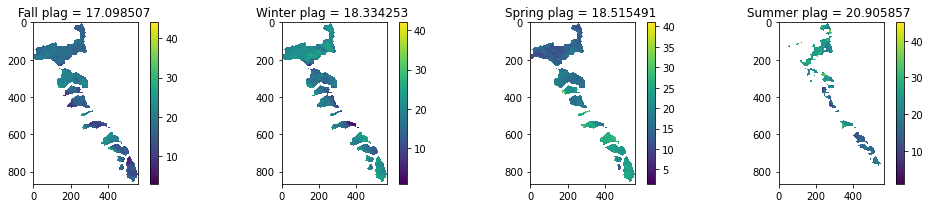

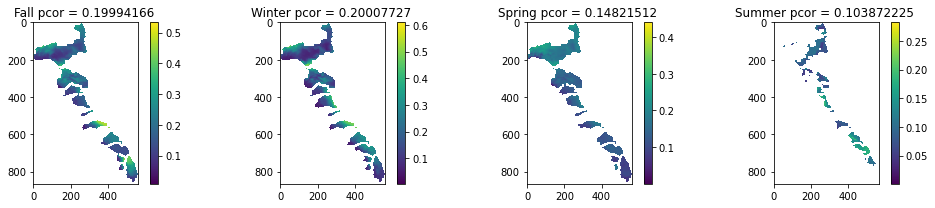

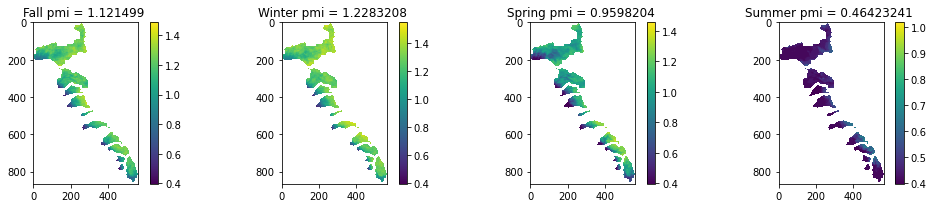

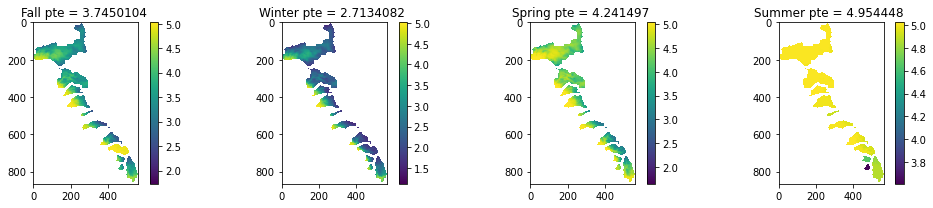

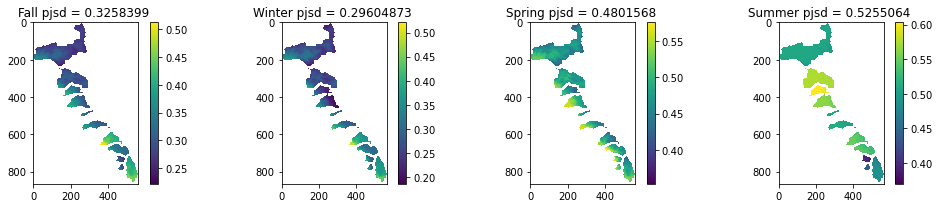

In [4]:
for hvar in p_vars:
    plot_outs(hvar)

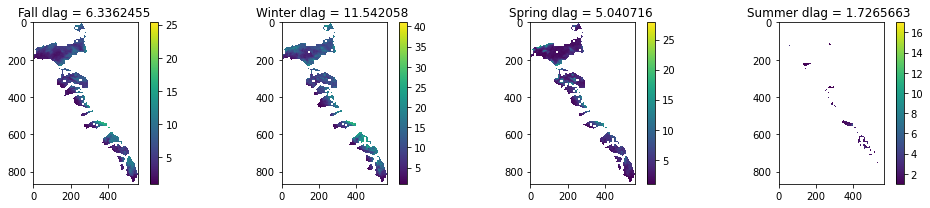

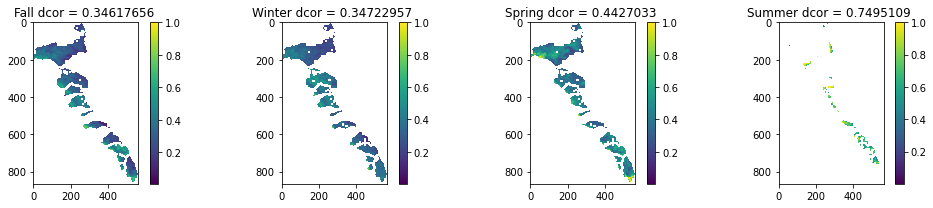

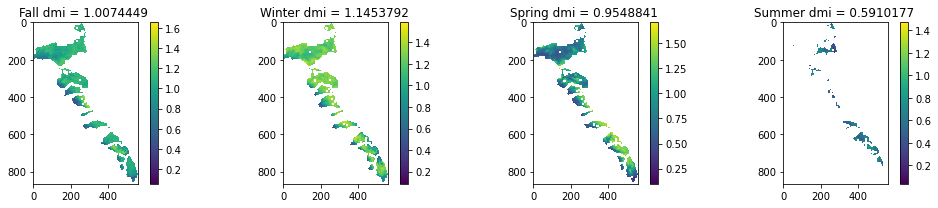

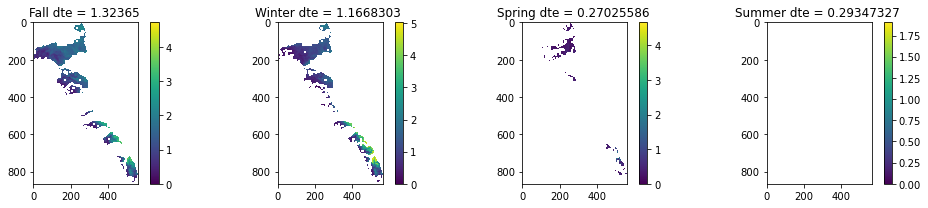

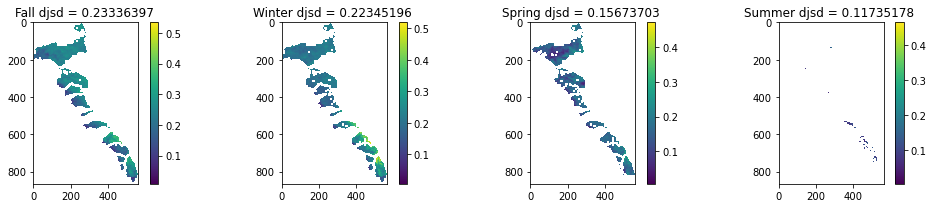

In [5]:
for hvar in d_vars:
    plot_outs(hvar)

In [6]:
# Create elevation contours


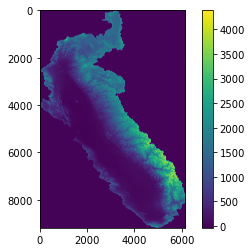

In [7]:
src = rio.open("../rasters/hu6_srtm_dem.tif")
arr = src.read(1)
plt.imshow(arr)
plt.colorbar()

# Cd into the ../rasters and run: 


```gdal_contour -a 'elev' hu6_srtm_dem.tif ../shape/contours_500m.shp -i 500.0 -p```

In [8]:
gdf

,outlet_id,area_km2,catch_name,stid,geometry
0,ENGLEBRIGHT (USACE),3782.8458,YUBA R,ENG,"POLYGON ((-120.87333 39.77667, -120.87000 39.7..."
1,PARDEE,1688.1372,MOKELUMNE R,PAR,"POLYGON ((-120.01583 38.66583, -120.01500 38.6..."
2,FRIANT DAM (MILLERTON),5003.0865,SAN JOAQUIN R,MIL,"POLYGON ((-119.17083 37.73750, -119.17000 37.7..."
3,ISABELLA DAM,6226.9884,KERN R,ISB,"POLYGON ((-118.40750 36.70083, -118.40500 36.7..."
4,DON PEDRO RESERVOIR,4722.4053,TUOLUMNE R,DNP,"POLYGON ((-119.65583 38.22833, -119.64917 38.2..."
5,NEW MELONES RESERVOIR,2801.7900,STANISLAUS R,NML,"POLYGON ((-119.92417 38.52000, -119.92167 38.5..."
6,OROVILLE DAM,11475.1485,FEATHER R,ORO,"POLYGON ((-121.22667 40.50083, -121.22333 40.5..."
7,FOLSOM LAKE,5838.1965,AMERICAN R,FOL,"POLYGON ((-120.60083 39.32083, -120.59833 39.3..."
8,TERMINUS DAM,1701.7128,KAWEAH R,TRM,"POLYGON ((-118.93333 36.72667, -118.93167 36.7..."
9,SUCCESS DAM,1182.0492,TULE R,SCC,"POLYGON ((-118.68083 36.33417, -118.67833 36.3..."


<ipython-input-9-c15115718ded>:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cmap.set_under('k', alpha=0)


<AxesSubplot:title={'center':'500m elevation contours '}>

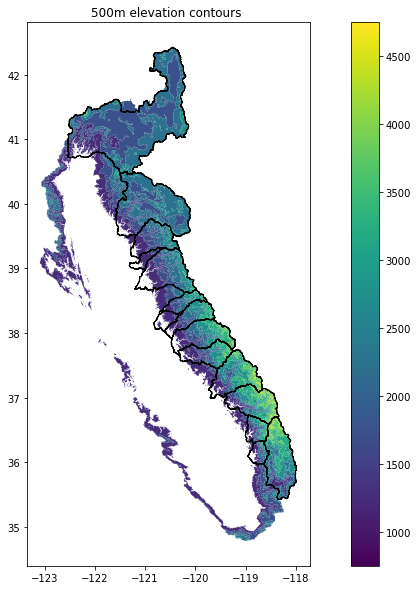

In [9]:
# Read contours we made 
cont_gdf = gp.read_file("../shape/contours_500m.shp")
cont_gdf['elev'] = np.linspace(250,4750,10) # [int(x) * 500 for x in gdf['ID']] 

# Set alpha val in cmap
cmap = plt.get_cmap('viridis')
cmap.set_under('k', alpha=0)

# plot with watersehds 
ax = cont_gdf.plot(figsize = (15,10), column= 'elev',cmap = cmap, legend = True, vmin = 751)
plt.title('500m elevation contours ')
gp.read_file("../shape/sierra_catchments.shp").plot(ax = ax, facecolor = "none", edgecolor = 'black')

In [10]:
len(cont_gdf)

10

In [11]:
# Define the 500m contour interval 

heights = np.linspace(0,5000,11)
heights = ["{} - {}".format(str(x-500), str(x)) for x in heights]
heights[0] = "<0"

median_hts = np.linspace(250,4750,10)

In [12]:
# Read each contour interval shape

with fiona.open("../rasters/elev_contours_500.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

len(shapes)

10

In [13]:
# Setup dicts to house final results
season_res_p = {}
season_res_d = {}

# loop through seasons
for season in seasons[:]: 
    
    # setup dict for seasonal results
    variable_res_p = {}
    variable_res_d = {}
    
    # loop through precip vars 
    for hvarname in tqdm(p_vars[:]):
                
        # find the merged file
        vardir = os.path.join("../rasters/seasonal_merged",hvarname)
        seasonal_var_fn = [os.path.join(vardir,x) for x in os.listdir(vardir) if season in x]
        
        # Set up dict for elevation results
        elev_res = {}
        
        # Loop through elevation contours
        for idx, shape in enumerate(shapes):
            with rasterio.open(seasonal_var_fn[0]) as src:
                out_image, out_transform = rasterio.mask.mask(src, [shape], crop=True)
                outim = out_image.reshape(out_image.shape[1],out_image.shape[2])
                outim[outim==-999]=np.nan #mask nodata vals 
                
                elev_res[heights[idx]] = outim[~np.isnan(outim)].flatten()
                
        # Compile summary stats for each elevation bin 
        df_rows = []
        for k,v in elev_res.items():
            varmean = np.nanmean(v)
            varstd = np.nanstd(v)
            var_n = len(v)
            sumdf = pd.DataFrame([k,varmean,varstd,var_n]).T
            sumdf.columns = ['elev','{}_mean'.format(hvarname),'{}_std'.format(hvarname),'{}_num'.format(hvarname)]
            df_rows.append(sumdf)
            
        # Concat the stats we just extracted 
        tdf = pd.concat(df_rows)
        tdf['elev'] = np.linspace(250,4750,10)
        tdf = tdf.astype(float).set_index("elev")
        
        variable_res_p[hvarname] = tdf
        
    seasonal_df_p = pd.concat([v for k,v in variable_res_p.items()], axis = 1)
    season_res_p[season] = seasonal_df_p
    
    
    # loop through dswe vars 
    for hvarname in tqdm(d_vars[:]):
                
        # find the merged file
        vardir = os.path.join("../rasters/seasonal_merged",hvarname)
        seasonal_var_fn = [os.path.join(vardir,x) for x in os.listdir(vardir) if season in x]
        
        # Set up dict for elevation results
        elev_res = {}
        
        # Loop through elevation contours
        for idx, shape in enumerate(shapes):
            with rasterio.open(seasonal_var_fn[0]) as src:
                out_image, out_transform = rasterio.mask.mask(src, [shape], crop=True)
                outim = out_image.reshape(out_image.shape[1],out_image.shape[2])
                outim[outim==-999]=np.nan #mask nodata vals 
                
                elev_res[heights[idx]] = outim[~np.isnan(outim)].flatten()
                
        # Compile summary stats for each elevation bin 
        df_rows = []
        for k,v in elev_res.items():
            varmean = np.nanmean(v)
            varstd = np.nanstd(v)
            var_n = len(v)
            sumdf = pd.DataFrame([k,varmean,varstd,var_n]).T
            sumdf.columns = ['elev','{}_mean'.format(hvarname),'{}_std'.format(hvarname),'{}_num'.format(hvarname)]
            df_rows.append(sumdf)
            
        # Concat the stats we just extracted 
        tdf = pd.concat(df_rows)
        tdf['elev'] = np.linspace(250,4750,10)
        tdf = tdf.astype(float).set_index("elev")
        
        variable_res_d[hvarname] = tdf
        
    seasonal_df_d = pd.concat([v for k,v in variable_res_d.items()], axis = 1)
    season_res_d[season] = seasonal_df_d

  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-13-cd4938740bed>:34: RuntimeWarning: Mean of empty slice
  varmean = np.nanmean(v)
/opt/anaconda3/envs/rsenv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-13-cd4938740bed>:74: RuntimeWarning: Mean of empty slice
  varmean = np.nanmean(v)
100%|██████████| 5/5 [01:02<00:00, 12.54s/it]


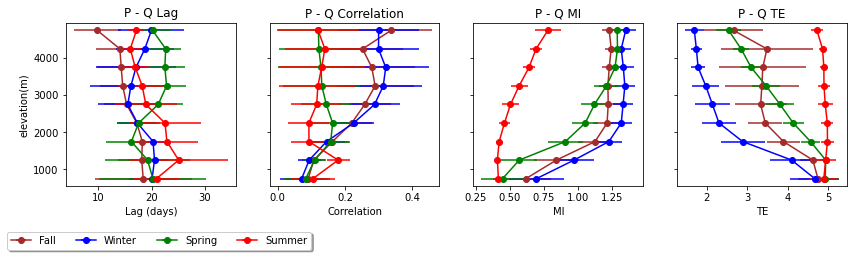

In [14]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(14, 3))

ax0.set_title("P - Q Lag")

ax0.errorbar(season_res_p['F']['plag_mean'], season_res_p['F'].index, xerr =season_res_p['F']['plag_std'],label = 'Fall', color = 'brown',marker='o' )
ax0.errorbar(season_res_p['W']['plag_mean'], season_res_p['F'].index, xerr =season_res_p['W']['plag_std'],label = 'Winter', color = 'blue',marker='o' )
ax0.errorbar(season_res_p['Sp']['plag_mean'], season_res_p['F'].index, xerr =season_res_p['Sp']['plag_std'],label = 'Spring', color = 'green',marker='o' )
ax0.errorbar(season_res_p['Su']['plag_mean'], season_res_p['F'].index, xerr =season_res_p['Su']['plag_std'],label = 'Summer', color = 'red',marker='o' )

ax0.set_ylabel("elevation(m)")
ax0.set_xlabel("Lag (days)")

ax0.legend()

ax0.legend(loc='upper center', bbox_to_anchor=(0.55, -.25), ncol=4, fancybox=True, shadow=True)


ax1.set_title("P - Q Correlation")

ax1.errorbar(season_res_p['F']['pcor_mean'], season_res_p['F'].index, xerr =season_res_p['F']['pcor_std'],color = 'brown',marker='o' )
ax1.errorbar(season_res_p['W']['pcor_mean'], season_res_p['F'].index, xerr =season_res_p['F']['pcor_std'], color = 'blue',marker='o' )
ax1.errorbar(season_res_p['Sp']['pcor_mean'], season_res_p['F'].index, xerr =season_res_p['F']['pcor_std'], color = 'green',marker='o' )
ax1.errorbar(season_res_p['Su']['pcor_mean'], season_res_p['F'].index, xerr =season_res_p['F']['pcor_std'], color = 'red',marker='o' )

ax1.set_xlabel("Correlation")

ax2.set_title("P - Q MI")

ax2.errorbar(season_res_p['F']['pmi_mean'], season_res_p['F'].index, xerr =season_res_p['F']['pmi_std'],color = 'brown',marker='o' )
ax2.errorbar(season_res_p['W']['pmi_mean'], season_res_p['F'].index, xerr =season_res_p['W']['pmi_std'], color = 'blue',marker='o' )
ax2.errorbar(season_res_p['Sp']['pmi_mean'], season_res_p['F'].index, xerr =season_res_p['Sp']['pmi_std'], color = 'green',marker='o' )
ax2.errorbar(season_res_p['Su']['pmi_mean'], season_res_p['F'].index, xerr =season_res_p['Su']['pmi_std'], color = 'red',marker='o' )

ax2.set_xlabel("MI")

ax3.set_title("P - Q TE")

ax3.errorbar(season_res_p['F']['pte_mean'], season_res_p['F'].index, xerr = season_res_p['F']['pte_std'],color = 'brown',marker='o' )
ax3.errorbar(season_res_p['W']['pte_mean'], season_res_p['F'].index, xerr = season_res_p['W']['pte_std'], color = 'blue',marker='o' )
ax3.errorbar(season_res_p['Sp']['pte_mean'], season_res_p['F'].index, xerr = season_res_p['Sp']['pte_std'], color = 'green',marker='o' )
ax3.errorbar(season_res_p['Su']['pte_mean'], season_res_p['F'].index, xerr = season_res_p['Su']['pte_std'], color = 'red',marker='o' )

ax3.set_xlabel("TE")

plt.show()

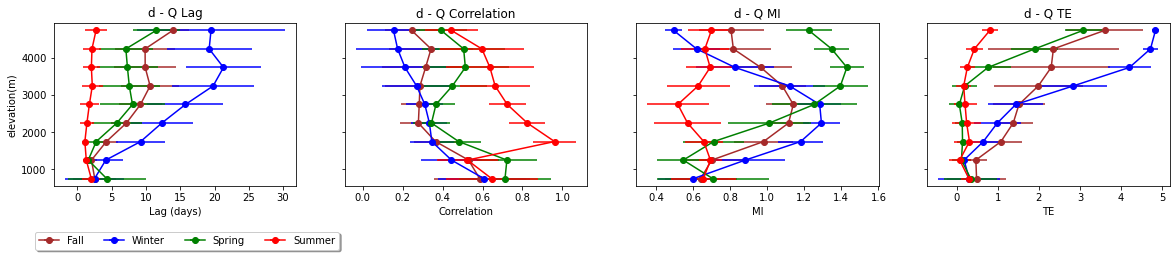

In [15]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=4, sharey=True, figsize=(20, 3))

ax0.set_title("d - Q Lag")

ax0.errorbar(season_res_d['F']['dlag_mean'], season_res_d['F'].index, xerr =season_res_d['F']['dlag_std'],label = 'Fall', color = 'brown',marker='o' )
ax0.errorbar(season_res_d['W']['dlag_mean'], season_res_d['F'].index, xerr =season_res_d['W']['dlag_std'],label = 'Winter', color = 'blue',marker='o' )
ax0.errorbar(season_res_d['Sp']['dlag_mean'], season_res_d['F'].index, xerr =season_res_d['Sp']['dlag_std'],label = 'Spring', color = 'green',marker='o' )
ax0.errorbar(season_res_d['Su']['dlag_mean'], season_res_d['F'].index, xerr =season_res_d['Su']['dlag_std'],label = 'Summer', color = 'red',marker='o' )

ax0.set_ylabel("elevation(m)")
ax0.set_xlabel("Lag (days)")

ax0.legend()

ax0.legend(loc='upper center', bbox_to_anchor=(0.55, -.25), ncol=4, fancybox=True, shadow=True)


ax1.set_title("d - Q Correlation")

ax1.errorbar(season_res_d['F']['dcor_mean'], season_res_d['F'].index, xerr =season_res_d['F']['dcor_std'],color = 'brown',marker='o' )
ax1.errorbar(season_res_d['W']['dcor_mean'], season_res_d['F'].index, xerr =season_res_d['F']['dcor_std'], color = 'blue',marker='o' )
ax1.errorbar(season_res_d['Sp']['dcor_mean'], season_res_d['F'].index, xerr =season_res_d['F']['dcor_std'], color = 'green',marker='o' )
ax1.errorbar(season_res_d['Su']['dcor_mean'], season_res_d['F'].index, xerr =season_res_d['F']['dcor_std'], color = 'red',marker='o' )

ax1.set_xlabel("Correlation")

ax2.set_title("d - Q MI")

ax2.errorbar(season_res_d['F']['dmi_mean'], season_res_d['F'].index, xerr =season_res_d['F']['dmi_std'],color = 'brown',marker='o' )
ax2.errorbar(season_res_d['W']['dmi_mean'], season_res_d['F'].index, xerr =season_res_d['W']['dmi_std'], color = 'blue',marker='o' )
ax2.errorbar(season_res_d['Sp']['dmi_mean'], season_res_d['F'].index, xerr =season_res_d['Sp']['dmi_std'], color = 'green',marker='o' )
ax2.errorbar(season_res_d['Su']['dmi_mean'], season_res_d['F'].index, xerr =season_res_d['Su']['dmi_std'], color = 'red',marker='o' )

ax2.set_xlabel("MI")

ax3.set_title("d - Q TE")

ax3.errorbar(season_res_d['F']['dte_mean'], season_res_d['F'].index, xerr = season_res_d['F']['dte_std'],color = 'brown',marker='o' )
ax3.errorbar(season_res_d['W']['dte_mean'], season_res_d['F'].index, xerr = season_res_d['W']['dte_std'], color = 'blue',marker='o' )
ax3.errorbar(season_res_d['Sp']['dte_mean'], season_res_d['F'].index, xerr = season_res_d['Sp']['dte_std'], color = 'green',marker='o' )
ax3.errorbar(season_res_d['Su']['dte_mean'], season_res_d['F'].index, xerr = season_res_d['Su']['dte_std'], color = 'red',marker='o' )

ax3.set_xlabel("TE")

plt.show()

In [16]:
numcols_d = [x for x in season_res_d['Su'].columns if "num" in x]

numdfs_d = []

for season in seasons:
    sdf = pd.DataFrame(season_res_d[season][numcols_d].mean(axis = 1))
    sdf.columns = [season]
    numdfs_d.append(sdf)
    
seasdf_d = pd.concat(numdfs_d, axis = 1)

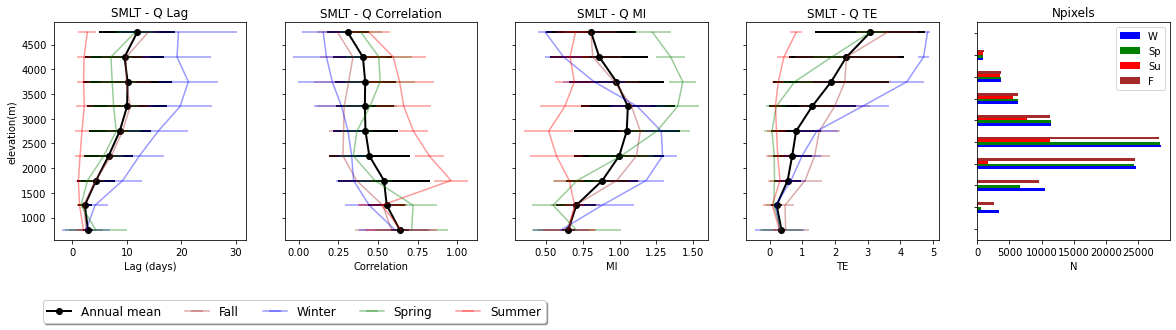

In [17]:
# Plot all metrics as f(elevation) for SNOWMELT

plt.figure(figsize=(20,4))

ax0 = plt.subplot(151)
ax0.set_title("SMLT - Q Lag")
varmean = pd.concat([season_res_d[key]['dlag_mean'] for key in season_res_d.keys()], axis=1).mean(axis = 1)
varstd = pd.concat([season_res_d[key]['dlag_mean'] for key in season_res_d.keys()], axis=1).std(axis = 1)
ax0.errorbar(varmean,varmean.index, xerr = varstd, color = 'black', label = 'Annual mean', linewidth = 2,marker='o')
ax0.errorbar(season_res_d['F']['dlag_mean'], season_res_d['F'].index, xerr =season_res_d['F']['dlag_std'],label = 'Fall', color = 'brown', alpha = 0.4)
ax0.errorbar(season_res_d['W']['dlag_mean'], season_res_d['F'].index, xerr =season_res_d['W']['dlag_std'],label = 'Winter', color = 'blue',alpha = 0.4 )
ax0.errorbar(season_res_d['Sp']['dlag_mean'], season_res_d['F'].index, xerr =season_res_d['Sp']['dlag_std'],label = 'Spring', color = 'green',alpha = 0.4 )
ax0.errorbar(season_res_d['Su']['dlag_mean'], season_res_d['F'].index, xerr =season_res_d['Su']['dlag_std'],label = 'Summer', color = 'red', alpha = 0.4 )

ax0.set_ylabel("elevation(m)")
ax0.set_xlabel("Lag (days)")

ax0.legend()

ax0.legend(loc='upper center', bbox_to_anchor=(1.25, -.25), ncol=5, fontsize = 12, fancybox=True, shadow=True)


ax1 = plt.subplot(152)
ax1.set_title("SMLT - Q Correlation")
varmean = pd.concat([season_res_d[key]['dcor_mean'] for key in season_res_d.keys()], axis=1).mean(axis = 1)
varstd = pd.concat([season_res_d[key]['dcor_mean'] for key in season_res_d.keys()], axis=1).std(axis = 1)
ax1.errorbar(varmean,varmean.index, xerr = varstd, color = 'black', label = 'Annual mean', linewidth = 2,marker='o')
ax1.errorbar(season_res_d['F']['dcor_mean'], season_res_d['F'].index, xerr =season_res_d['F']['dcor_std'],color = 'brown', alpha = 0.4)
ax1.errorbar(season_res_d['W']['dcor_mean'], season_res_d['F'].index, xerr =season_res_d['F']['dcor_std'], color = 'blue', alpha = 0.4)
ax1.errorbar(season_res_d['Sp']['dcor_mean'], season_res_d['F'].index, xerr =season_res_d['F']['dcor_std'], color = 'green', alpha = 0.4 )
ax1.errorbar(season_res_d['Su']['dcor_mean'], season_res_d['F'].index, xerr =season_res_d['F']['dcor_std'], color = 'red', alpha = 0.4)
ax1.set(yticklabels=[])  
ax1.set_xlabel("Correlation")

ax2 = plt.subplot(153)
ax2.set_title("SMLT - Q MI")
varmean = pd.concat([season_res_d[key]['dmi_mean'] for key in season_res_d.keys()], axis=1).mean(axis = 1)
varstd = pd.concat([season_res_d[key]['dmi_mean'] for key in season_res_d.keys()], axis=1).std(axis = 1)
ax2.errorbar(varmean,varmean.index, xerr = varstd, color = 'black', label = 'Annual mean', linewidth = 2,marker='o')
ax2.errorbar(season_res_d['F']['dmi_mean'], season_res_d['F'].index, xerr =season_res_d['F']['dmi_std'],color = 'brown', alpha = 0.4 )
ax2.errorbar(season_res_d['W']['dmi_mean'], season_res_d['F'].index, xerr =season_res_d['W']['dmi_std'], color = 'blue', alpha = 0.4 )
ax2.errorbar(season_res_d['Sp']['dmi_mean'], season_res_d['F'].index, xerr =season_res_d['Sp']['dmi_std'], color = 'green', alpha = 0.4 )
ax2.errorbar(season_res_d['Su']['dmi_mean'], season_res_d['F'].index, xerr =season_res_d['Su']['dmi_std'], color = 'red', alpha = 0.4 )
ax2.set(yticklabels=[])  
ax2.set_xlabel("MI")

ax3 = plt.subplot(154)
ax3.set_title("SMLT - Q TE")
varmean = pd.concat([season_res_d[key]['dte_mean'] for key in season_res_d.keys()], axis=1).mean(axis = 1)
varstd = pd.concat([season_res_d[key]['dte_mean'] for key in season_res_d.keys()], axis=1).std(axis = 1)
ax3.errorbar(varmean,varmean.index, xerr = varstd, color = 'black', label = 'Annual mean', linewidth = 2,marker='o')
ax3.errorbar(season_res_d['F']['dte_mean'], season_res_d['F'].index, xerr = season_res_d['F']['dte_std'],color = 'brown', alpha = 0.4)
ax3.errorbar(season_res_d['W']['dte_mean'], season_res_d['F'].index, xerr = season_res_d['W']['dte_std'], color = 'blue', alpha = 0.4)
ax3.errorbar(season_res_d['Sp']['dte_mean'], season_res_d['F'].index, xerr = season_res_d['Sp']['dte_std'], color = 'green', alpha = 0.4)
ax3.errorbar(season_res_d['Su']['dte_mean'], season_res_d['F'].index, xerr = season_res_d['Su']['dte_std'], color = 'red', alpha = 0.4)
ax3.set(yticklabels=[])  
ax3.set_xlabel("TE")

plt.subplot(155)
ax4 = seasdf_d.plot(kind = 'barh', ax = plt.gca(),color = ['blue', 'green', 'red', 'brown'])
ax4.set(yticklabels=[])  
ax4.set_ylabel("")  
ax4.set_xlabel("N")  
ax4.set_title("Npixels")
plt.show()

In [18]:
numcols_p = [x for x in season_res_p['Su'].columns if "num" in x]

numdfs_p = []

for season in seasons:
    sdf = pd.DataFrame(season_res_p[season][numcols_p].mean(axis = 1))
    sdf.columns = [season]
    numdfs_p.append(sdf)
    
seasdf_p = pd.concat(numdfs_p, axis = 1)

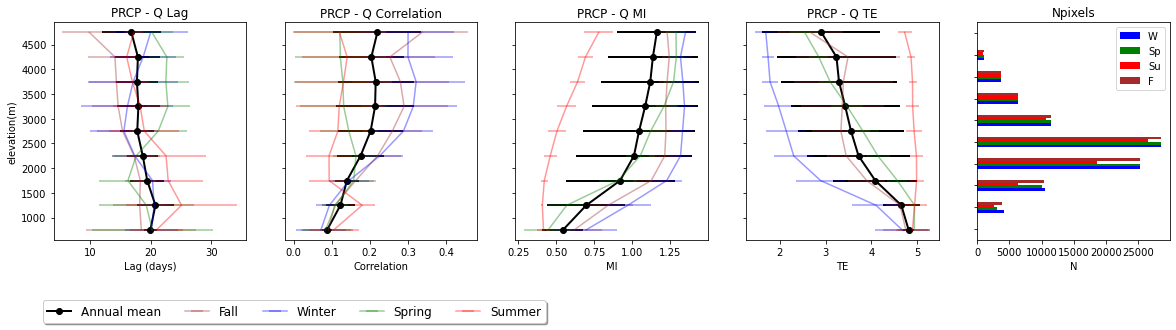

In [19]:
# Plot all metrics as f(elevation) for Liquid Precip

plt.figure(figsize=(20,4))

ax0 = plt.subplot(151)
ax0.set_title("PRCP - Q Lag")
varmean = pd.concat([season_res_p[key]['plag_mean'] for key in season_res_p.keys()], axis=1).mean(axis = 1)
varstd = pd.concat([season_res_p[key]['plag_mean'] for key in season_res_p.keys()], axis=1).std(axis = 1)
ax0.errorbar(varmean,varmean.index, xerr = varstd, color = 'black', label = 'Annual mean', linewidth = 2,marker='o')
ax0.errorbar(season_res_p['F']['plag_mean'], season_res_p['F'].index, xerr =season_res_p['F']['plag_std'],label = 'Fall', color = 'brown',alpha = 0.4)
ax0.errorbar(season_res_p['W']['plag_mean'], season_res_p['F'].index, xerr =season_res_p['W']['plag_std'],label = 'Winter', color = 'blue',alpha = 0.4)
ax0.errorbar(season_res_p['Sp']['plag_mean'], season_res_p['F'].index, xerr =season_res_p['Sp']['plag_std'],label = 'Spring', color = 'green',alpha = 0.4)
ax0.errorbar(season_res_p['Su']['plag_mean'], season_res_p['F'].index, xerr =season_res_p['Su']['plag_std'],label = 'Summer', color = 'red',alpha = 0.4)

ax0.set_ylabel("elevation(m)")
ax0.set_xlabel("Lag (days)")

ax0.legend(loc='upper center', bbox_to_anchor=(1.25, -.25), ncol=5, fontsize = 12, fancybox=True, shadow=True)


ax1 = plt.subplot(152)
ax1.set_title("PRCP - Q Correlation")
varmean = pd.concat([season_res_p[key]['pcor_mean'] for key in season_res_p.keys()], axis=1).mean(axis = 1)
varstd = pd.concat([season_res_p[key]['pcor_mean'] for key in season_res_p.keys()], axis=1).std(axis = 1)
ax1.errorbar(varmean,varmean.index, xerr = varstd, color = 'black', label = 'Annual mean', linewidth = 2,marker='o')
ax1.errorbar(season_res_p['F']['pcor_mean'], season_res_p['F'].index, xerr =season_res_p['F']['pcor_std'],color = 'brown',alpha = 0.4)
ax1.errorbar(season_res_p['W']['pcor_mean'], season_res_p['F'].index, xerr =season_res_p['F']['pcor_std'], color = 'blue',alpha = 0.4)
ax1.errorbar(season_res_p['Sp']['pcor_mean'], season_res_p['F'].index, xerr =season_res_p['F']['pcor_std'], color = 'green',alpha = 0.4)
ax1.errorbar(season_res_p['Su']['pcor_mean'], season_res_p['F'].index, xerr =season_res_p['F']['pcor_std'], color = 'red',alpha = 0.4)
ax1.set(yticklabels=[])  
ax1.set_xlabel("Correlation")

ax2 = plt.subplot(153)
ax2.set_title("PRCP - Q MI")
varmean = pd.concat([season_res_p[key]['pmi_mean'] for key in season_res_p.keys()], axis=1).mean(axis = 1)
varstd = pd.concat([season_res_p[key]['pmi_mean'] for key in season_res_p.keys()], axis=1).std(axis = 1)
ax2.errorbar(varmean,varmean.index, xerr = varstd, color = 'black', label = 'Annual mean', linewidth = 2,marker='o')
ax2.errorbar(season_res_p['F']['pmi_mean'], season_res_p['F'].index, xerr =season_res_p['F']['pmi_std'],color = 'brown',alpha = 0.4)
ax2.errorbar(season_res_p['W']['pmi_mean'], season_res_p['F'].index, xerr =season_res_p['W']['pmi_std'], color = 'blue',alpha = 0.4)
ax2.errorbar(season_res_p['Sp']['pmi_mean'], season_res_p['F'].index, xerr =season_res_p['Sp']['pmi_std'], color = 'green',alpha = 0.4)
ax2.errorbar(season_res_p['Su']['pmi_mean'], season_res_p['F'].index, xerr =season_res_p['Su']['pmi_std'], color = 'red',alpha = 0.4)
ax2.set(yticklabels=[])  
ax2.set_xlabel("MI")

ax3 = plt.subplot(154)
ax3.set_title("PRCP - Q TE")
varmean = pd.concat([season_res_p[key]['pte_mean'] for key in season_res_p.keys()], axis=1).mean(axis = 1)
varstd = pd.concat([season_res_p[key]['pte_mean'] for key in season_res_p.keys()], axis=1).std(axis = 1)
ax3.errorbar(varmean,varmean.index, xerr = varstd, color = 'black', label = 'Annual mean', linewidth = 2,marker='o')
ax3.errorbar(season_res_p['F']['pte_mean'], season_res_p['F'].index, xerr = season_res_p['F']['pte_std'],color = 'brown',alpha = 0.4)
ax3.errorbar(season_res_p['W']['pte_mean'], season_res_p['F'].index, xerr = season_res_p['W']['pte_std'], color = 'blue',alpha = 0.4)
ax3.errorbar(season_res_p['Sp']['pte_mean'], season_res_p['F'].index, xerr = season_res_p['Sp']['pte_std'], color = 'green',alpha = 0.4)
ax3.errorbar(season_res_p['Su']['pte_mean'], season_res_p['F'].index, xerr = season_res_p['Su']['pte_std'], color = 'red',alpha = 0.4)
ax3.set(yticklabels=[])  
ax3.set_xlabel("TE")

plt.subplot(155)
ax4 = seasdf_p.plot(kind = 'barh', ax = plt.gca(),color = ['blue', 'green', 'red', 'brown'])
ax4.set(yticklabels=[])  
ax4.set_ylabel("")  
ax4.set_xlabel("N")  
ax4.set_title("Npixels")

plt.show()

In [99]:
elev_vals = np.linspace(250,4750,10)

elevs = []
varvals = []

for idx,(k,v) in enumerate(elev_res.items()):
    if v is None:
        continue
    
    length = len(v)
    xarr = np.ones_like(range(0,length)) * elev_vals[idx]
    elevs.append(xarr)
    varvals.append(v)

elevs = [item for sublist in elevs for item in sublist]
varvals = [item for sublist in varvals for item in sublist]

elevdf_full = pd.DataFrame([elevs,varvals]).T
elevdf_full.columns = ['elev', '{}'.format(hvar)]


In [102]:
elevdf_full

,elev,djsd
0,750.0,0.253208
1,750.0,0.260436
2,750.0,0.270533
3,750.0,0.263744
4,750.0,0.247698
...,...,...
88634,4750.0,0.402286
88635,4750.0,0.373093
88636,4750.0,0.374972
88637,4750.0,0.377876


In [96]:
elevs = []
varvals = []

for idx,vals in enumerate(elev_res.values()):

    if x is None:
        continue
    
    length = len(vals)
    xarr = np.ones_like(range(0,length)) * elev_vals[idx]
    elevs.append(xarr)
    varvals.append(vals)
    

In [49]:
len(vals)

12

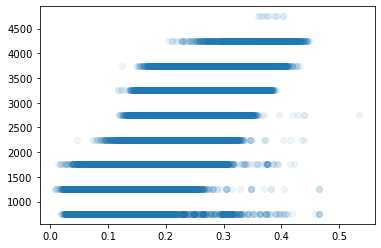

In [63]:
xplt = [item for sublist in xall for item in sublist]
yplt = [item for sublist in yall for item in sublist]

pltdf = pd.DataFrame([xplt,yplt]).T
pltdf.columns = ['elev','var']

plt.scatter(yplt, xplt, alpha = 0.07)

AttributeError: 'FacetGrid' object has no attribute 'errorbar'

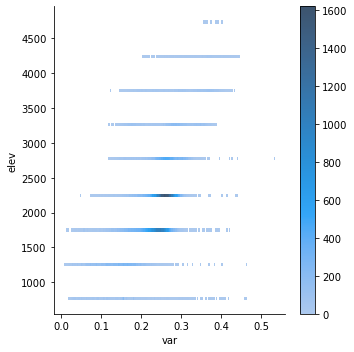

In [85]:
import seaborn as sns

ax = sns.displot(pltdf, x="var", y="elev", cbar=True)
ax.errorbar(season_res_p['W']['pte_mean'], season_res_p['F'].index, xerr = season_res_p['W']['pte_std'], color = 'blue',alpha = 0.4)


/opt/anaconda3/envs/rsenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<ErrorbarContainer object of 3 artists>

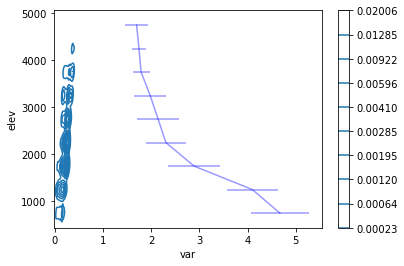

In [86]:
ax = sns.kdeplot(pltdf['var'],pltdf['elev'], cbar=True)
ax.errorbar(season_res_p['W']['pte_mean'], season_res_p['F'].index, xerr = season_res_p['W']['pte_std'], color = 'blue',alpha = 0.4)



In [ ]:
# Setup dicts to house final results
seas_res_p_all = {}
seas_res_d_all = {}

# loop through seasons
for season in seasons[:]: 
    
    # setup dict for seasonal results
    var_res_p_all = {}
    var_res_d_all = {}
    
    # loop through precip vars 
    for hvarname in tqdm(p_vars[:]):
                
        # find the merged file
        vardir = os.path.join("../rasters/seasonal_merged",hvarname)
        seasonal_var_fn = [os.path.join(vardir,x) for x in os.listdir(vardir) if season in x]
        
        # Set up dict for elevation results
        elev_res = {}
        
        # Loop through elevation contours
        for idx, shape in enumerate(shapes):
            with rasterio.open(seasonal_var_fn[0]) as src:
                out_image, out_transform = rasterio.mask.mask(src, [shape], crop=True)
                outim = out_image.reshape(out_image.shape[1],out_image.shape[2])
                outim[outim==-999]=np.nan #mask nodata vals 
                
                elev_res[heights[idx]] = outim[~np.isnan(outim)].flatten()
                
        # Compile summary stats for each elevation bin 
        elev_vals = np.linspace(250,4750,10)

        elevs = []
        varvals = []

        for idx,(k,v) in enumerate(elev_res.items()):
            if v is None:
                continue

            length = len(v)
            xarr = np.ones_like(range(0,length)) * elev_vals[idx]
            elevs.append(xarr)
            varvals.append(v)

        elevs = [item for sublist in elevs for item in sublist]
        varvals = [item for sublist in varvals for item in sublist]

        elevdf_full = pd.DataFrame([elevs,varvals]).T
        elevdf_full.columns = ['elev', '{}'.format(hvar)]

        variable_res_p[hvarname] = elevdf_full
        
    seasonal_df_p_all = pd.concat([v for k,v in variable_res_p.items()], axis = 1)
    seas_res_p_all[season] = seasonal_df_p_all
    
    
    # loop through dswe vars 
    for hvarname in tqdm(d_vars[:]):
                
        # find the merged file
        vardir = os.path.join("../rasters/seasonal_merged",hvarname)
        seasonal_var_fn = [os.path.join(vardir,x) for x in os.listdir(vardir) if season in x]
        
        # Set up dict for elevation results
        elev_res = {}
        
        # Loop through elevation contours
        for idx, shape in enumerate(shapes):
            with rasterio.open(seasonal_var_fn[0]) as src:
                out_image, out_transform = rasterio.mask.mask(src, [shape], crop=True)
                outim = out_image.reshape(out_image.shape[1],out_image.shape[2])
                outim[outim==-999]=np.nan #mask nodata vals 
                
                elev_res[heights[idx]] = outim[~np.isnan(outim)].flatten()
                
        # Compile summary stats for each elevation bin 
        df_rows = []
        for k,v in elev_res.items():
            varmean = np.nanmean(v)
            varstd = np.nanstd(v)
            var_n = len(v)
            sumdf = pd.DataFrame([k,varmean,varstd,var_n]).T
            sumdf.columns = ['elev','{}_mean'.format(hvarname),'{}_std'.format(hvarname),'{}_num'.format(hvarname)]
            df_rows.append(sumdf)
            
        # Concat the stats we just extracted 
        tdf = pd.concat(df_rows)
        tdf['elev'] = np.linspace(250,4750,10)
        tdf = tdf.astype(float).set_index("elev")
        
        variable_res_d[hvarname] = tdf
        
    seasonal_df_d = pd.concat([v for k,v in variable_res_d.items()], axis = 1)
    season_res_d[season] = seasonal_df_d